## Steps for processing

1. Prepare presence localities
2. Prepare pseudo-absence localities
3. Define GEE covariates to extract
4. Extract covariates
5. Export as a csv
6. Create HS models
7. Create GLM models
8. Comapre variable importances and contributions

In [ ]:
import num

### Import packages used in analysis

In [1]:
import geopandas as gpd
import numpy as np
import pandas as pd
import geemap
# geemap.update_package()
import ee
ee.Initialize()

### Create a map Object to visualise rasters and vectors

In [2]:
Map = geemap.Map()
Map

Map(center=[40, -100], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=HBox(children=(T…

In [3]:
countries = ee.FeatureCollection("USDOS/LSIB/2017")
geometry = ee.Geometry.Point([27.7,-25.5])
SA = countries.filterBounds(geometry).geometry()
# SA = ee.Feature(countries.filterBounds(geometry).geometry()).buffer(100000).geometry()
# Map.addLayer(SA)

### 1. Prepare WH Presence localities

In [4]:
Presence = gpd.read_file(r"D:\phd\Chapter_3\nat_drivers\1inputs\SA_waterbodies\with_WH_2013.shp")

DriverError: D:\phd\Chapter_3\nat_drivers\1inputs\SA_waterbodies\with_WH_2013.shp: No such file or directory

In [6]:
Presence['label'] = 1
Presence

,gridcode,ORIG_FID,geometry,label
0,1,0,"POLYGON ((20.04000 -34.78900, 20.04000 -34.789...",1
1,1,0,"POLYGON ((19.89750 -34.76250, 19.89825 -34.762...",1
2,1,0,"POLYGON ((19.90225 -34.76275, 19.90225 -34.763...",1
3,1,0,"POLYGON ((19.90575 -34.76300, 19.90575 -34.763...",1
4,1,0,"POLYGON ((19.91350 -34.76175, 19.91325 -34.761...",1
...,...,...,...,...
27201,1,1,"POLYGON ((29.24975 -22.18829, 29.25175 -22.188...",1
27202,1,1,"POLYGON ((29.24947 -22.18825, 29.24900 -22.188...",1
27203,1,1,"POLYGON ((29.18600 -22.19025, 29.18600 -22.190...",1
27204,1,1,"POLYGON ((29.67075 -22.17600, 29.67050 -22.176...",1


### 2. Prepare WH Absence localities

In [7]:
Absence = gpd.read_file(r"D:\phd\Chapter_3\nat_drivers\1inputs\SA_waterbodies\no_WH_2013.shp")

In [8]:
Absence['label'] = 0
Absence

,gridcode,ORIG_FID,geometry,label
0,1,0,"POLYGON ((19.99925 -34.83300, 19.99900 -34.833...",0
1,1,0,"POLYGON ((20.00675 -34.83175, 20.00650 -34.831...",0
2,1,0,"POLYGON ((19.98000 -34.82425, 19.98025 -34.824...",0
3,1,0,"POLYGON ((19.98000 -34.82425, 19.97975 -34.824...",0
4,1,0,"POLYGON ((19.97450 -34.82150, 19.97475 -34.821...",0
...,...,...,...,...
221159,1,1,"POLYGON ((29.66955 -22.13725, 29.66925 -22.137...",0
221160,1,1,"POLYGON ((29.66907 -22.13700, 29.66900 -22.137...",0
221161,1,1,"POLYGON ((29.64575 -22.13550, 29.64475 -22.135...",0
221162,1,1,"POLYGON ((29.63650 -22.13350, 29.63625 -22.133...",0


Run next cell on first execution only.
creates a single shp with combined presence(label=1) and absence(label=0) water system localities

In [51]:
# gdf = Presence.append(Absence)
# gdf.label.value_counts()
# gdf.to_file(r"D:\phd\Chapter_3\nat_drivers\1inputs\WH_wbs.shp")

### 3. Define GEE covariates to extract

#### List of Covariates that will be used:
1. Minimum temperature/ night temperature
2. Water seasonality
3. Precipitation
4. Distance to the coast
5. Elevation
6. CHILI (a surrogate for effects of insolation and topographic shading)
7. Global Human Modification
8. Topographic Diversity (a surrogate variable that represents the variety of temperature and moisture conditions available to species as local habitats)
9. Area of different landcover within 1km buffer
10. EVI ( a proxy of vegetation health)
11. water Nutrient levels
12. Competition (IAAP/Site Area)
13. Recuitment Suitability (area of shallow water)
14. Connectivity (Zoochory)
15. Connectivity (Hydrochory)
16. Connectivity (human aided dispersal)- distance from roads




#### 1. Minimum Temperature (Celsius)

In [19]:
# minT = ee.ImageCollection("MODIS/006/MOD11A1").filterBounds(SA).select('LST_Night_1km')
minT = ee.Image("WORLDCLIM/V1/BIO").select(["bio06"]).multiply(0.1).rename('minT').clip(SA)
Map.addLayer(minT,{'min':-15,'max':20, 'palette':['440154', '481567', '482677', '453781', '404788', '39568C', '33638D', '2D708E', '287D8E', '238A8D', '1F968B', '20A387', '29AF7F', '3CBB75', '55C667', '73D055', '95D840', 'B8DE29', 'DCE319', 'FDE725']},'minT')

#### 2. Water Seasonality

In [25]:
#Water- seasonality
startDate = ee.Date('2013-01-01')
endDate = ee.Date('2013-12-31')
water = ee.Image('JRC/GSW1_2/GlobalSurfaceWater')
wSeasonality = water.select(['seasonality']).unmask().rename('wSeasonality')
Map.addLayer(wSeasonality,{},'seasonality')
# print(seasonality.getInfo())

#### 3. Precipitation

In [21]:
#Precipitation (~5km)

rain = ee.ImageCollection("IDAHO_EPSCOR/TERRACLIMATE").select(['pr'])

totalPrecipitation = rain.filterDate(startDate,endDate).sum().rename('precipitation').clip(SA)
Map.addLayer(totalPrecipitation,{},'Precipitation')

#### 4. Distance to Coast

In [23]:
#distance from the coast
D2Coast = ee.Image('users/zandersamuel/Global_misc/GMT_intermediate_coast_distance_01d').rename('distance_from_coast').clip(SA)
Map.addLayer(D2Coast,{},'distance from coast')

#### 5. Elevation

In [8]:
#elevation
elevation = ee.Image("NASA/NASADEM_HGT/001").select('elevation').clip(SA)
Map.addLayer(elevation,{},'elevation')
# ee.Image("MERIT/DEM/v1_0_3")

#### 6. CHILI

In [9]:
chili = ee.Image('CSP/ERGo/1_0/Global/SRTM_CHILI').rename('CHILI').clip(SA)
Map.addLayer(chili,{},'CHILI')

#### 7. Global Human Modififcation

In [10]:
ghm = ee.ImageCollection('CSP/HM/GlobalHumanModification')
GHM = ghm.mosaic().rename('Global_Human_Modification').clip(SA)
Map.addLayer(GHM,{},'Global Human Modification')

#### 8. Topographic Diversity

In [11]:
topD = ee.Image('CSP/ERGo/1_0/Global/SRTM_topoDiversity').rename('topD').clip(SA)
Map.addLayer(topD,{},'topographic diversity')

#### 9. Frost duration and Frost degree days

In [26]:
frost = ee.Image('users/geethensingh/frostdur').unmask().clip(SA).rename('frost')
Map.addLayer(frost,{},'frost')

In [28]:
#number of days with a temperature less than 0 degrees celsius in 2013

modis = ee.ImageCollection("MODIS/006/MOD11A1").filter(ee.Filter.calendarRange(2013,2013,'year')).select('LST_Night_1km').filterBounds(SA)    
# print(modis.sort('system:time_start',false).first())

def islt0 (img):
  lt0 = img.multiply(0.02).subtract(273.15).lt(0)
  return lt0

FDs = modis.map(islt0).reduce(ee.Reducer.count()).clip(SA).rename('Tlt0')
Map.addLayer(FDs,{},'FDs');

In [29]:
# test_s = ee.ImageCollection("COPERNICUS/Landcover/100m/Proba-V-C3/Global").select('.*coverfraction').getRegion(EG_CR_sample.first().geometry(),100).getInfo()
# print(test_s[:5])

#### 10. Number of days with temperature less than 10 dgrees

In [30]:
#number of days with a temperature less than 10 degrees celsius in 2013

modis = ee.ImageCollection("MODIS/006/MOD11A1").filter(ee.Filter.calendarRange(2013,2013,'year')).select('LST_Night_1km').filterBounds(SA)    
# print(modis.sort('system:time_start',false).first())

def islt10 (img):
  lt10 = img.multiply(0.02).subtract(273.15).lt(10)
  return lt10

FDs10 = modis.map(islt10).reduce(ee.Reducer.count()).rename('Tlt10')
# Map.addLayer(FDs10,{},'FDs');

## 4. Merge (non-Buffer) covariates as stack/multiband image

In [31]:
months = (['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec'])#
covariates = minT.addBands([wSeasonality, totalPrecipitation ,D2Coast,elevation,chili,GHM,topD, frost, FDs, FDs10])
print(covariates.bandNames().getInfo())
# Map.addLayer(covariates,{},'covariates')

['minT', 'wSeasonality', 'precipitation', 'distance_to_coast', 'elevation', 'CHILI', 'Global_Human_Modification', 'topD', 'frost', 'Tlt0', 'Tlt10']


## 5. Export stacked covariates to GEE Asset

In [32]:
task = ee.batch.Export.image.toAsset(**{'image':covariates,'description':'covs', 'assetId':'users/geethensingh/WH_covariates','region':SA.geometry(), 'scale':100, 'maxPixels':1e13})
task.start()

In [53]:
task.status()

{'state': 'COMPLETED',
 'description': 'covs',
 'creation_timestamp_ms': 1614327981177,
 'update_timestamp_ms': 1614330190564,
 'start_timestamp_ms': 1614327989642,
 'task_type': 'EXPORT_IMAGE',
 'destination_uris': ['https://code.earthengine.google.com/?asset=projects/earthengine-legacy/assets/users/geethensingh/WH_covariates'],
 'attempt': 1,
 'id': 'J65RAHPIKDE4TW3OTE2FLKRP',
 'name': 'projects/earthengine-legacy/operations/J65RAHPIKDE4TW3OTE2FLKRP'}

## 6. Additional_vars

#### 15. max duration of period less than 10

In [30]:
# modis = ee.ImageCollection("MODIS/006/MOD11A1").filter(ee.Filter.calendarRange(2013,2013,'year')).select('LST_Night_1km').filterBounds(SA)    

# def islt10 (img):
#   lt10 = img.multiply(0.02).subtract(273.15).lt(10)
#   return lt10

# FDs10 = modis.map(islt10)#.reduce(ee.Reducer.count()).rename('Tlt10')

# def consecutiveDays(this_img, cum_prev_max):
#   cum_img = ee.Image(cum_prev_max).select(0) #//load cumulative # days
#   prev_img = ee.Image(cum_prev_max).select(1) #//load prev day's image
#   max_run = ee.Image(cum_prev_max).select(2) #//load maximum # consecutive data
#   this_img = this_img.unmask() #//set masked pixels to 0
#   cum_img = cum_img.where(this_img.eq(1).And(prev_img.eq(1)), cum_img.add(1)) #// if this and previous day were > 50, record this consecutive day 
#   cum_img = cum_img.where(this_img.neq(1), 0) #//if < 50 deg, reset counter
#   max_run = max_run.where(cum_img.gt(max_run),cum_img)
#   return cum_img.addBands(this_img).addBands(max_run) #//this return value becomes cum_prev input

# max_value = 40
# T50plus = ee.ImageCollection(FDs10.toList(max_value))

# max = ee.Image(T50plus.iterate(consecutiveDays, ee.Image([0,0,0]))).select(2).add(1).clip(SA) #// need to add 1 day to get # days rather than # two-date periods > 50 deg 
# # print('max # consecutive days > 50 image',max.getInfo())
# # Map.addLayer(max,{min: 0, max: max_value}, "max # consecutive days > 50")

# # cum = ee.Image(T50plus.iterate(consecutiveDays, ee.Image([0,0,0]))).select(0).add(1).clip(SA)
# # Map.addLayer(cum,{min: 0, max: max_value}, "cumulative # consecutive days > 50",False)

#### 12. Competition

In [4]:
WH13 = ee.Image("users/geethensingh/SA_hyacinth2013")
aq_veg = WH13.eq(0).selfMask().multiply(ee.Image.pixelArea()).rename('aq_veg_area') 
macro_veg = ee.Image.cat([aq_veg])
# print(macro_veg.bandNames().getInfo())

# Stream power index

In [5]:
spi = ee.ImageCollection("projects/sat-io/open-datasets/Geomorpho90m/spi").filterBounds(SA).mosaic().clip(SA).rename('SPI')

# Distance to roads

In [6]:
grip = ee.FeatureCollection("projects/sat-io/open-datasets/GRIP4/Africa").filterBounds(SA).distance().rename('distance_to_roads')
print(grip.bandNames().getInfo())

['distance_to_roads']


# Wind speeds

In [7]:
wind_speed= ee.ImageCollection('projects/earthengine-legacy/assets/projects/sat-io/open-datasets/global_wind_atlas/wind-speed')\
.filterBounds(SA).mosaic().clip(SA).rename('wind_speed')

## 6. Read extracted covariates

In [4]:
# grid for aggregating shap
# Generate a random image of integers in Albers projection at the specified cell size.
seed = 123
cellSize = 5000

proj = ee.Projection("EPSG:3857").atScale(cellSize)
cells = ee.Image.random(seed).multiply(1e6).int().reproject(proj).rename('pxid')
Map.addLayer(cells.randomVisualizer())

In [5]:
print(cells.getInfo())

{'type': 'Image', 'bands': [{'id': 'pxid', 'data_type': {'type': 'PixelType', 'precision': 'int', 'min': -2147483648, 'max': 2147483647}, 'crs': 'EPSG:3857', 'crs_transform': [5000, 0, 0, 0, 5000, 0]}]}


In [10]:
# covariates = ee.Image('users/geethensingh/WH_covariates').addBands([max.rename('maxDslt10'),macro_veg, spi, grip, wind_speed])
# print(covariates.bandNames().getInfo())
covariates = ee.Image('users/geethensingh/WH_covariates').select('minT', 'wSeasonality', 'precipitation', 'distance_to_coast', 'CHILI', 'Global_Human_Modification', 'topD').addBands([macro_veg, spi, grip, wind_speed, cells])
print(covariates.bandNames().getInfo())

['minT', 'wSeasonality', 'precipitation', 'distance_to_coast', 'CHILI', 'Global_Human_Modification', 'topD', 'aq_veg_area', 'SPI', 'distance_to_roads', 'wind_speed', 'pxid']


## 7. covs: part 2- feature vars

#### 13. Connectivity (hydrochory) and relative wealth index

In [4]:
rvs = ee.FeatureCollection("WWF/HydroSHEDS/v1/FreeFlowingRivers")
rwi = ee.FeatureCollection("projects/sat-io/open-datasets/facebook/relative_wealth_index")
grwl = ee.FeatureCollection("projects/sat-io/open-datasets/GRWL/grwl_SummaryStats_v01_01");

#     ee.Feature(gridcells.filterBounds(ft.geometry()).first()).get('label')
def connectivity(ft):
    reaches = rvs.filterBounds(ft.geometry())
    ft = ft.set('dsrcnt',reaches.filter(ee.Filter.gt('NDOID',0)).size())
    #ft = ft.set('usrcnt',reaches.filter(ee.Filter.gt('NUOID',0)).size())
    ft = ft.set('rwi', rwi.filterBounds(ft.geometry()).aggregate_mean('rwi'))
    ft = ft.set('grwl', grwl.filterBounds(ft.geometry()).aggregate_mean('width_med'))
    ft = ft.set('warea', ft.area().divide(1e6))
    ft = ft.set('pxid', covariates.select('pxid').reduceRegion(ee.Reducer.first(), ft.geometry() ,30).get('pxid'))
    return ft

###  Covariates (5km buffer): part 3

## 7. Split shapefile into portions, buffer and extract remaining variables

#### 11. Area of Landcover within buffer

In [5]:
bufferSize = 5000 #in metres

def buffer (feature):
    feature = feature.set('ft_area',feature.area(2))
    buffer_ft = feature.buffer(bufferSize)
    return buffer_ft

In [6]:
cats = ['contiguous (indigenous) forest',
 'contiguous low forest & thicket',
 'dense forest & woodland',
 'open woodland',
 'contiguous & dense plantation forest',
 'open & sparse plantation forest',
 'temporary unplanted (clear-felled) plantation forest',
 'low shrubland (other)',
 'low shrubland (fynbos)',
 'low shrubland (succulent karoo)',
 'low shrubland (nama karoo)',
 'sparsely wooded grassland',
 'natural grassland',
 'natural rivers',
 'natural estuaries & lagoons',
 'natural ocean & coastal',
 'natural lakes',
 'natural pans (flooded @ observation times)',
 'artificial dams (including canals)',
 'artificial sewage ponds',
 'artificial flooded mine pits',
 'herbaceous wetlands (currently mapped)',
 'herbaceous wetlands (previously mapped)',
 'mangrove wetlands',
 'natural rock surfaces',
 'dry pans',
 'eroded lands',
 'sand dunes (terrestrial)',
 'coastal sand & dunes',
 'bare riverbed material',
 'other bare',
 'cultivated commercial permanent orchards',
 'cultivated commercial permanent vines',
 'cultivated commercial sugarcane pivot irrigated',
 'cultivated commercial permanent pineapples',
 'cultivated commercial sugarcane non-pivot',
 'cultivated emerging farmer sugarcane non-pivot',
 'commercial annual crops pivot irrigated',
 'commercial annual crops non-pivot irrigated',
 'commercial annual crops rain-fed / dryland',
 'subsistence / small-scale annual crops',
 'fallow land & old fields (trees)',
 'fallow land & old fields (bush)',
 'fallow land & old fields (grass)',
 'fallow land & old fields (bare)',
 'fallow land & old fields (low shrub)',
 'residential formal (tree)',
 'residential formal (bush)',
 'residential formal (low veg / grass)',
 'residential formal (bare)',
 'residential informal (tree)',
 'residential informal (bush)',
 'residential informal (low veg / grass)',
 'residential informal (bare)',
 'village scattered (bare & low veg/ grss combo)',
 'village dense (bare & low veg / grss combo)',
 'smallholdings (tree)',
 'smallholdings (bush)',
 'smallholdings (low veg / grass)',
 'smallholdings (bare)',
 'urban recreational fields (tree)',
 'urban recreational fields (bush)',
 'urban recreational fields (grass)',
 'urban recreational fields (bare)',
 'commercial',
 'industrial',
 'roads & rails (major linear)',
 'mines: surface infrastructure',
 'mines: extraction pits, quarries',
 'mines: salt mines',
 'mine: tailings and resource dumps',
 'land-fills',
 'fallow land & old fields (wetlands)']

cats = ee.List(cats)

In [7]:
#functions to format dictionary from SANLC
def unpack(list_item):
    areaDict = ee.Dictionary(list_item)
    cat = cats.get(ee.Number(areaDict.get('b1')).subtract(1))
    area = ee.Number(areaDict.get('sum')).divide(1e6)
    return ee.List([cat, area])

def classAreas (ft):
    opt = ee.List(ft.get('groups')).map(unpack)
    return ee.Feature(ft.geometry(),ee.Dictionary(opt.flatten()));

#### Detailed LC (SANLC)

In [8]:
SANLC = ee.Image("users/geethensingh/SANLC__2013_14").rename('SANLC')

#### 14. Water Nutrients proxy (riparian N, SOC and phh20)

#### 16. Flooding (refer to 13 connectivity)

In [9]:
Lcov_fracs = ['bare-coverfraction', 'urban-coverfraction', 'crops-coverfraction', 'grass-coverfraction', 'moss-coverfraction', 'water-permanent-coverfraction', 'water-seasonal-coverfraction', 'shrub-coverfraction', 'tree-coverfraction']
LC = ee.Image(ee.ImageCollection("COPERNICUS/Landcover/100m/Proba-V-C3/Global").first().select(Lcov_fracs).clip(SA))

In [14]:
# N = ee.Image('projects/soilgrids-isric/nitrogen_mean')
SOC = ee.Image("projects/soilgrids-isric/soc_mean").select('soc_100-200cm_mean')
# phh20 = ee.Image("projects/soilgrids-isric/phh2o_mean")
flood = ee.Image("users/geethensingh/floodMapGL_rp10y").rename('flood').clip(SA)
mnnlrnff = ee.Image("users/geethensingh/SA_MAR").rename('runoff')

bedrock_depth = ee.Image("projects/sat-io/open-datasets/iSDAsoil_Africa_30m/bedrock_depth").select('b1').rename('bedrock_depth')
bulk_density = ee.Image("projects/sat-io/open-datasets/iSDAsoil_Africa_30m/bulk_density").select('b1').rename('bulk_density');
carbon_organic = ee.Image("projects/sat-io/open-datasets/iSDAsoil_Africa_30m/carbon_organic").select('b1').rename('carbon_organic');
carbon_total = ee.Image("projects/sat-io/open-datasets/iSDAsoil_Africa_30m/carbon_total").select('b1').rename('carbon_total');
cation_exchange_capacity = ee.Image("projects/sat-io/open-datasets/iSDAsoil_Africa_30m/cation_exchange_capacity").select('b1').rename('cation_ex_capacity');
clay_content = ee.Image("projects/sat-io/open-datasets/iSDAsoil_Africa_30m/clay_content").select('b1').rename('clay_content');
fertility_capability_classification = ee.Image("projects/sat-io/open-datasets/iSDAsoil_Africa_30m/fcc").select('b1').rename('fcc');
nitrogen_total = ee.Image("projects/sat-io/open-datasets/iSDAsoil_Africa_30m/nitrogen_total").select('b1').rename('nitrogen_total');
ph = ee.Image("projects/sat-io/open-datasets/iSDAsoil_Africa_30m/ph").select('b1').divide(10).rename('ph');
sand_content = ee.Image("projects/sat-io/open-datasets/iSDAsoil_Africa_30m/sand_content").select('b1').rename('sand_content');
silt_content = ee.Image("projects/sat-io/open-datasets/iSDAsoil_Africa_30m/silt_content").select('b1').rename('silt_content');
stone_content = ee.Image("projects/sat-io/open-datasets/iSDAsoil_Africa_30m/stone_content").select('b1').rename('stone_content');
texture_class = ee.Image("projects/sat-io/open-datasets/iSDAsoil_Africa_30m/texture_class").select('b1').rename('texture_class');

soil_vars = bedrock_depth.addBands([bulk_density, carbon_organic,\
                                    carbon_total, cation_exchange_capacity,\
                                    clay_content,fertility_capability_classification,\
                                    nitrogen_total, ph, sand_content, silt_content,\
                                    stone_content, texture_class]).clip(SA)

buffer_cov = ee.Image.cat([LC, SOC,flood, mnnlrnff, soil_vars])
print(buffer_cov.bandNames().getInfo())

['bare-coverfraction', 'urban-coverfraction', 'crops-coverfraction', 'grass-coverfraction', 'moss-coverfraction', 'water-permanent-coverfraction', 'water-seasonal-coverfraction', 'shrub-coverfraction', 'tree-coverfraction', 'soc_100-200cm_mean', 'flood', 'runoff', 'bedrock_depth', 'bulk_density', 'carbon_organic', 'carbon_total', 'cation_ex_capacity', 'clay_content', 'fcc', 'nitrogen_total', 'ph', 'sand_content', 'silt_content', 'stone_content', 'texture_class']


In [10]:
spatialFilter = ee.Filter.intersects(**{
  'leftField': '.geo',
  'rightField': '.geo',
  'maxError': 5
});

simpleJoin = ee.Join.saveFirst(**{'matchKey':'matches'});

def formatter (f):
    f1 = ee.Feature(f)
    f2 = ee.Feature(f.get('matches')).toDictionary()
    return ee.Feature(f1).set(f2).set('matches', None)

# RenderJSON(result.getInfo())


In [11]:
#Grid for block CV
grid = ee.FeatureCollection('users/geethensingh/SA_Grid_1dgr')
# // Define a save all join.
saveFirstJoin = ee.Join.saveFirst(**{'matchKey': 'matches',});

### Sanity check

In [34]:
#Sanity Check
shp_dir = r"D:\phd\Chapter_3\nat_drivers\1inputs\WH_wbs.shp"
shp = gpd.read_file(shp_dir, rows = 5)
ee_shp = geemap.geopandas_to_ee(shp)
vars1 = covariates.reduceRegions(**{'collection': ee_shp,'reducer': ee.Reducer.mean(),'scale': 30, 'tileScale': 8})
# RenderJSON(buffer_covs2.getInfo())
                #extracts part 2 vars: feature
ft_cov = vars1.map(connectivity)
# Get grid ID.
ft_cov = saveFirstJoin.apply(ft_cov, grid, spatialFilter).map(formatter)
# RenderJSON(vars1.getInfo())
                #extract part 3 vars: ft with buffer SANLC
buffer_poly = ft_cov.map(buffer)
buffer_covs1 = (ee.Image.pixelArea().addBands(SANLC).reduceRegions(**{'collection': buffer_poly,
                              'reducer': ee.Reducer.sum().group(**{'groupField': 1, 'groupName': 'b1'}),
                                       'scale': 30, 'tileScale': 8}).map(classAreas))
              #extract part 3 vars: ft with buffer
buffer_covs2 = (buffer_cov.reduceRegions(**{'collection' : buffer_covs1, 'reducer':ee.Reducer.mean()
                                                     ,'scale':30, 'tileScale' : 8}))
# RenderJSON(buffer_cov.getInfo())
fc_joined = simpleJoin.apply(ft_cov, buffer_covs2, spatialFilter);
result = (fc_joined.map(formatter))
RenderJSON(result.getInfo())

In [16]:
shp_dir = r"D:\phd\Chapter_2\nat_drivers\1inputs\WH_wbs.shp"
shp = gpd.read_file(shp_dir)

In [6]:
int(len(shp))

248370

In [34]:
def shp_job_splitter(shp, features_per_split, GD_folder_name):
    shp=shp
    tsks=1
    for i in range(0,len(shp), features_per_split):
        if tsks >3000-2:
            input('click enter')
            tsks = 1
        if i+features_per_split > len(shp):
            data = np.split(shp, range(i, len(shp) , features_per_split))#list of lists
            print(i)
            tsks += features_per_split
        else:
            data = shp.iloc[i:i+features_per_split,:]
            print(len(data))
           #gpddf = gpd.GeoDataFrame(data)
            ee_shp = geemap.geopandas_to_ee(data)
            task_name = 'Export_batch'+ str(int(round(i/features_per_split+1)))
            print('Executing...'+ task_name)
            tsks += features_per_split

In [35]:
shp_job_splitter(shp, 30, 'Earth_Engine')

30
Executing...Export_batch1
30
Executing...Export_batch2
30
Executing...Export_batch3
30
Executing...Export_batch4
30
Executing...Export_batch5
30
Executing...Export_batch6
30
Executing...Export_batch7
30
Executing...Export_batch8
30
Executing...Export_batch9
30
Executing...Export_batch10
30
Executing...Export_batch11
30
Executing...Export_batch12
30
Executing...Export_batch13
30
Executing...Export_batch14
30
Executing...Export_batch15
30
Executing...Export_batch16
30
Executing...Export_batch17
30
Executing...Export_batch18
30
Executing...Export_batch19
30
Executing...Export_batch20
30
Executing...Export_batch21
30
Executing...Export_batch22
30
Executing...Export_batch23
30
Executing...Export_batch24
30
Executing...Export_batch25
30
Executing...Export_batch26
30
Executing...Export_batch27
30
Executing...Export_batch28
30
Executing...Export_batch29
30
Executing...Export_batch30
30
Executing...Export_batch31
30
Executing...Export_batch32
30
Executing...Export_batch33
30
Executing...Expo

KeyboardInterrupt: Interrupted by user

# Export covariates

In [12]:
# covariates = ee.Image('users/geethensingh/WH_covariates').addBands([max.rename('maxDslt10'),macro_veg, spi, grip, wind_speed])
# print(covariates.bandNames().getInfo())
covariates = ee.Image('users/geethensingh/WH_covariates').select('minT', 'wSeasonality', 'precipitation', 'distance_to_coast', 'CHILI', 'Global_Human_Modification', 'topD').addBands([macro_veg, spi, grip, wind_speed, cells, SANLC, SOC, flood, mnnlrnff, soil_vars])
print(covariates.bandNames().getInfo())

NameError: name 'macro_veg' is not defined

In [19]:
task = ee.batch.Export.image.toAsset(**{'image':covariates,'description':'Chapter2_covs_v2', 'assetId':'users/geethensingh/Chapter2_covariates_V2','region':SA, 'scale':30, 'maxPixels':1e13})
task.start()

# Read final covariates

In [12]:
covariates = ee.Image('users/geethensingh/Chapter2_covariates_V2')
print(covariates.bandNames().getInfo())

['minT', 'wSeasonality', 'precipitation', 'distance_to_coast', 'CHILI', 'Global_Human_Modification', 'topD', 'aq_veg_area', 'SPI', 'distance_to_roads', 'wind_speed', 'pxid', 'SANLC', 'soc_100-200cm_mean', 'flood', 'runoff', 'bedrock_depth', 'bulk_density', 'carbon_organic', 'carbon_total', 'cation_ex_capacity', 'clay_content', 'fcc', 'nitrogen_total', 'ph', 'sand_content', 'silt_content', 'stone_content', 'texture_class']


In [13]:
# covs p1 - no buffer
covsp1 = covariates.select(['minT', 'wSeasonality', 'precipitation', 'distance_to_coast', 'CHILI', 'Global_Human_Modification', 'topD', 'aq_veg_area', 'SPI', 'distance_to_roads', 'wind_speed'])
# buffer covs
covsp3 = covariates.select(['soc_100-200cm_mean', 'flood', 'runoff', 'bedrock_depth', 'bulk_density', 'carbon_organic',\
                            'carbon_total', 'cation_ex_capacity', 'clay_content', 'fcc', 'nitrogen_total', 'ph',\
                            'sand_content', 'silt_content', 'stone_content', 'texture_class']).addBands(LC)

print(covsp3.bandNames().getInfo())

['soc_100-200cm_mean', 'flood', 'runoff', 'bedrock_depth', 'bulk_density', 'carbon_organic', 'carbon_total', 'cation_ex_capacity', 'clay_content', 'fcc', 'nitrogen_total', 'ph', 'sand_content', 'silt_content', 'stone_content', 'texture_class', 'bare-coverfraction', 'urban-coverfraction', 'crops-coverfraction', 'grass-coverfraction', 'moss-coverfraction', 'water-permanent-coverfraction', 'water-seasonal-coverfraction', 'shrub-coverfraction', 'tree-coverfraction']


## Step 3. Extract Covariates

In [14]:
def shp_job_splitter(shp_dir, features_per_split, GD_folder_name):
    shp = gpd.read_file(shp_dir)
    tsks=1
    for i in range(248370,len(shp), features_per_split):
        if tsks >3000-2:
            input("Click here once previous 2k(x) tasks have completed")
            tsks = 1
        if i+features_per_split > len(shp):
            data = shp.iloc[i:len(shp),:]
            ee_shp = geemap.geopandas_to_ee(data)
            #extracts part 1 vars
            vars1 = covsp1.reduceRegions(**{'collection': ee_shp,'reducer': ee.Reducer.mean(),'scale': 30, 'tileScale': 8})
            #extracts part 2 vars: feature
            ft_cov = vars1.map(connectivity)
            # Get grid ID.
            ft_cov = saveFirstJoin.apply(ft_cov, grid, spatialFilter).map(formatter)
            #extract part 3 vars: ft with buffer SANLC
            buffer_poly = ft_cov.map(buffer)
            buffer_covs1 = (ee.Image.pixelArea().addBands(SANLC).reduceRegions(**{'collection': buffer_poly,
                                              'reducer': ee.Reducer.sum().group(**{'groupField': 1, 'groupName': 'b1'}),
                                                       'scale': 30, 'tileScale': 8}).map(classAreas))
            #extract part 3 vars: ft with buffer
            buffer_covs2 = (covsp3.reduceRegions(**{'collection' : buffer_covs1, 'reducer':ee.Reducer.mean()
                                                                     ,'scale':30, 'tileScale' : 8}))
            # RenderJSON(buffer_cov.getInfo())
            fc_joined = simpleJoin.apply(ft_cov, buffer_covs2, spatialFilter);
            result = (fc_joined.map(formatter))
            task_name = 'Export_batch' + str(int(round(i/features_per_split+1)))
            print('Executing...'+ task_name)
            task = ee.batch.Export.table.toDrive(result, task_name, GD_folder_name)
            task.start()
            tsks += 1
        else:
            data = shp.iloc[i:i+features_per_split,:]
            ee_shp = geemap.geopandas_to_ee(data)
            #extracts part 1 vars
            vars1 = covsp1.reduceRegions(**{'collection': ee_shp,'reducer': ee.Reducer.mean(),'scale': 30, 'tileScale': 8})
            #extracts part 2 vars: feature
            ft_cov = vars1.map(connectivity)
            # Get grid ID.
            ft_cov = saveFirstJoin.apply(ft_cov, grid, spatialFilter).map(formatter)
            #extract part 3 vars: ft with buffer SANLC
            buffer_poly = ft_cov.map(buffer)
            buffer_covs1 = (ee.Image.pixelArea().addBands(SANLC).reduceRegions(**{'collection': buffer_poly,
                                              'reducer': ee.Reducer.sum().group(**{'groupField': 1, 'groupName': 'b1'}),
                                                       'scale': 30, 'tileScale': 8}).map(classAreas))
            #extract part 3 vars: ft with buffer
            buffer_covs2 = (covsp3.reduceRegions(**{'collection' : buffer_covs1, 'reducer':ee.Reducer.mean()
                                                                     ,'scale':30, 'tileScale' : 8}))
            # RenderJSON(buffer_cov.getInfo())
            fc_joined = simpleJoin.apply(ft_cov, buffer_covs2, spatialFilter);
            result = (fc_joined.map(formatter))
            task_name = 'Export_batch_' + str(int(round(i/features_per_split+1)))
            print('Executing...'+ task_name)
            task = ee.batch.Export.table.toDrive(result, task_name, GD_folder_name)
            task.start()
            tsks += 1

In [15]:
shp_dir = r"D:\phd\Chapter_2\nat_drivers\1inputs\WH_wbs.shp"
shp_job_splitter(shp_dir, 10, 'ee_Chapter_2_24082021')

In [ ]:
831
950
969
970
973
989
992

## Step 4. Exploratory data analysis

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy.stats import norm
from sklearn.preprocessing import StandardScaler
from scipy import stats
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

In [6]:
import sweetviz as sv
my_report = sv.compare_intra(df, df["label"] == 1, ["Hyacinth Present", "Hyacinth Absent"], target_feat ='label')
my_report.show_html()

                                             |                                             | [  0%]   00:00 ->…

Report SWEETVIZ_REPORT.html was generated! NOTEBOOK/COLAB USERS: the web browser MAY not pop up, regardless, the report IS saved in your notebook/colab files.


In [4]:
# df = pd.read_csv(r'D:\phd\Chapter_3\nat_drivers\1inputs\merged.csv')
# df = pd.read_csv(r'D:\phd\Chapter_3\nat_drivers\3exports\merged.csv')
df = pd.read_csv(r'D:\phd\Chapter_3\nat_drivers\3exports\merged_13052021_p1.csv')

In [5]:
df =df.drop(['Unnamed: 0','ORIG_FID','.geo','system:index', 'nx', 'ny','gridcode','matches','moss-coverfraction', 'snow-coverfraction'], axis =1)

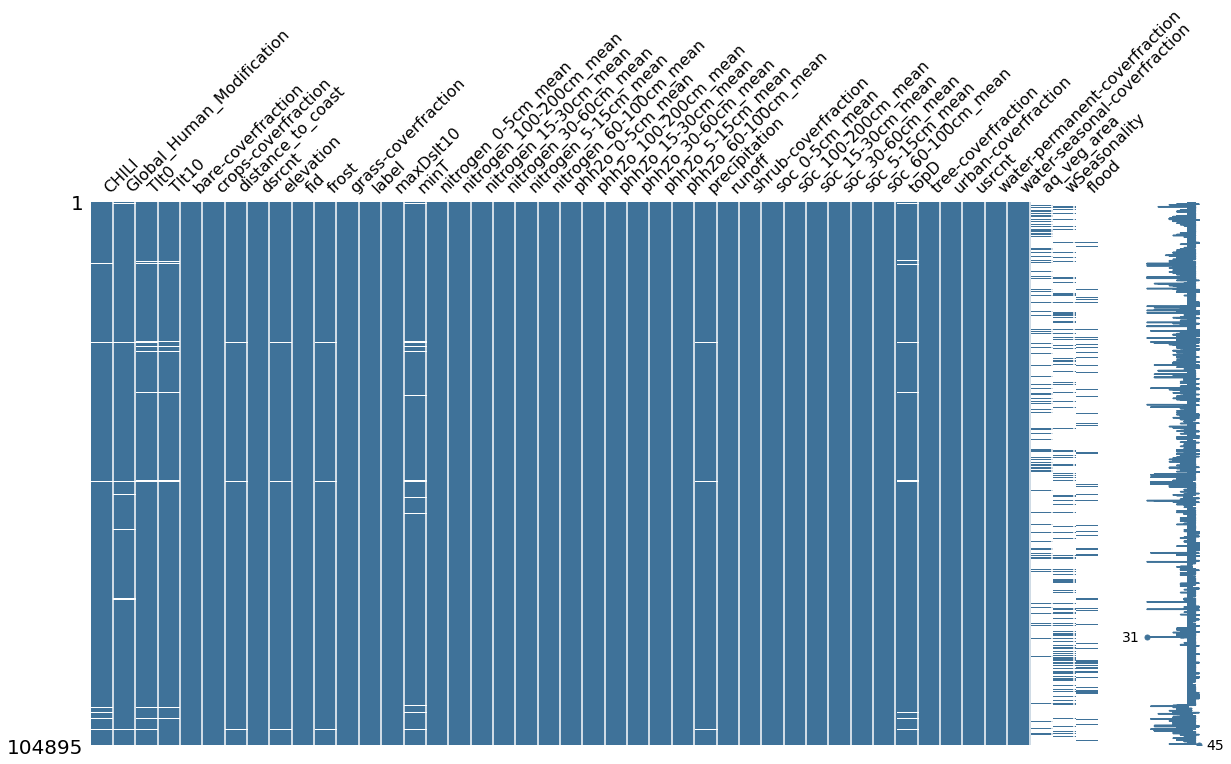

In [23]:
import missingno as msno
df =df.drop([*FLC,'Unnamed: 0','ORIG_FID','.geo','system:index', 'nx', 'ny','gridcode','matches','moss-coverfraction', 'snow-coverfraction'], axis =1)
msno.matrix(df, inline=True, sparkline=True, figsize=(20,10), sort=None, color=(0.25, 0.45, 0.6))

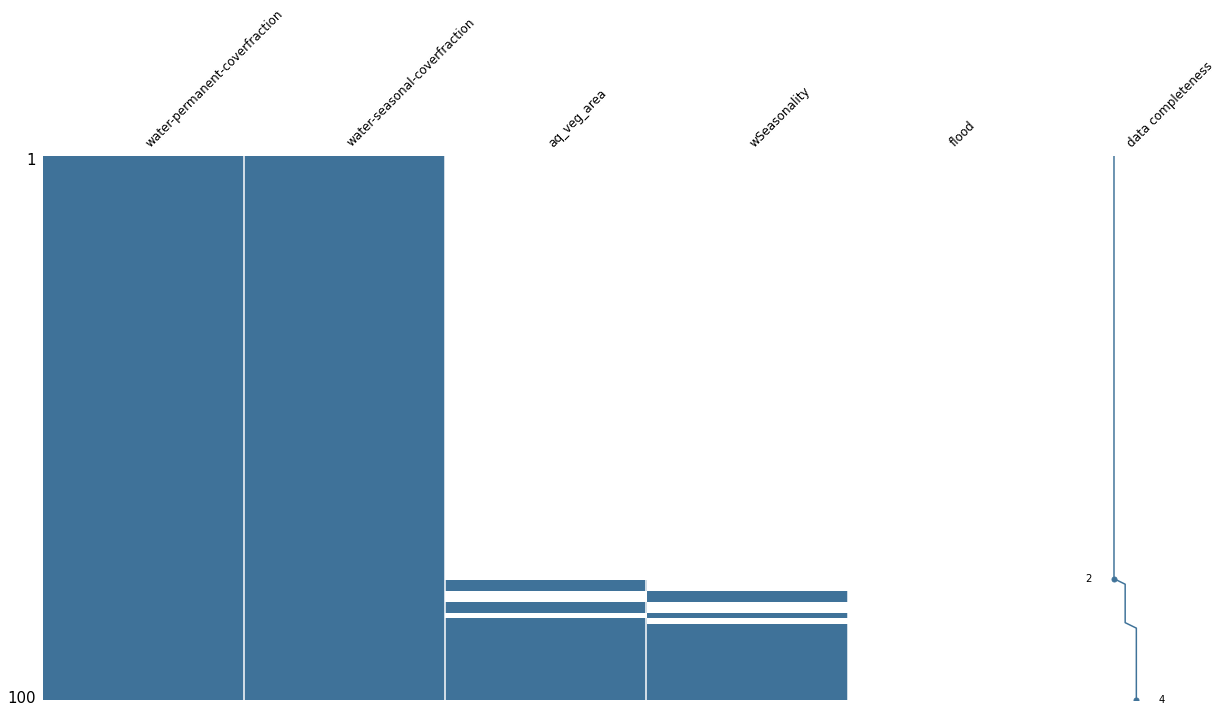

In [24]:
msno.matrix(df.iloc[0:100, 40:94], inline=True, sparkline=True, figsize=(20,10), sort='ascending', fontsize=12, labels=True, color=(0.25, 0.45, 0.6))

<AxesSubplot:>

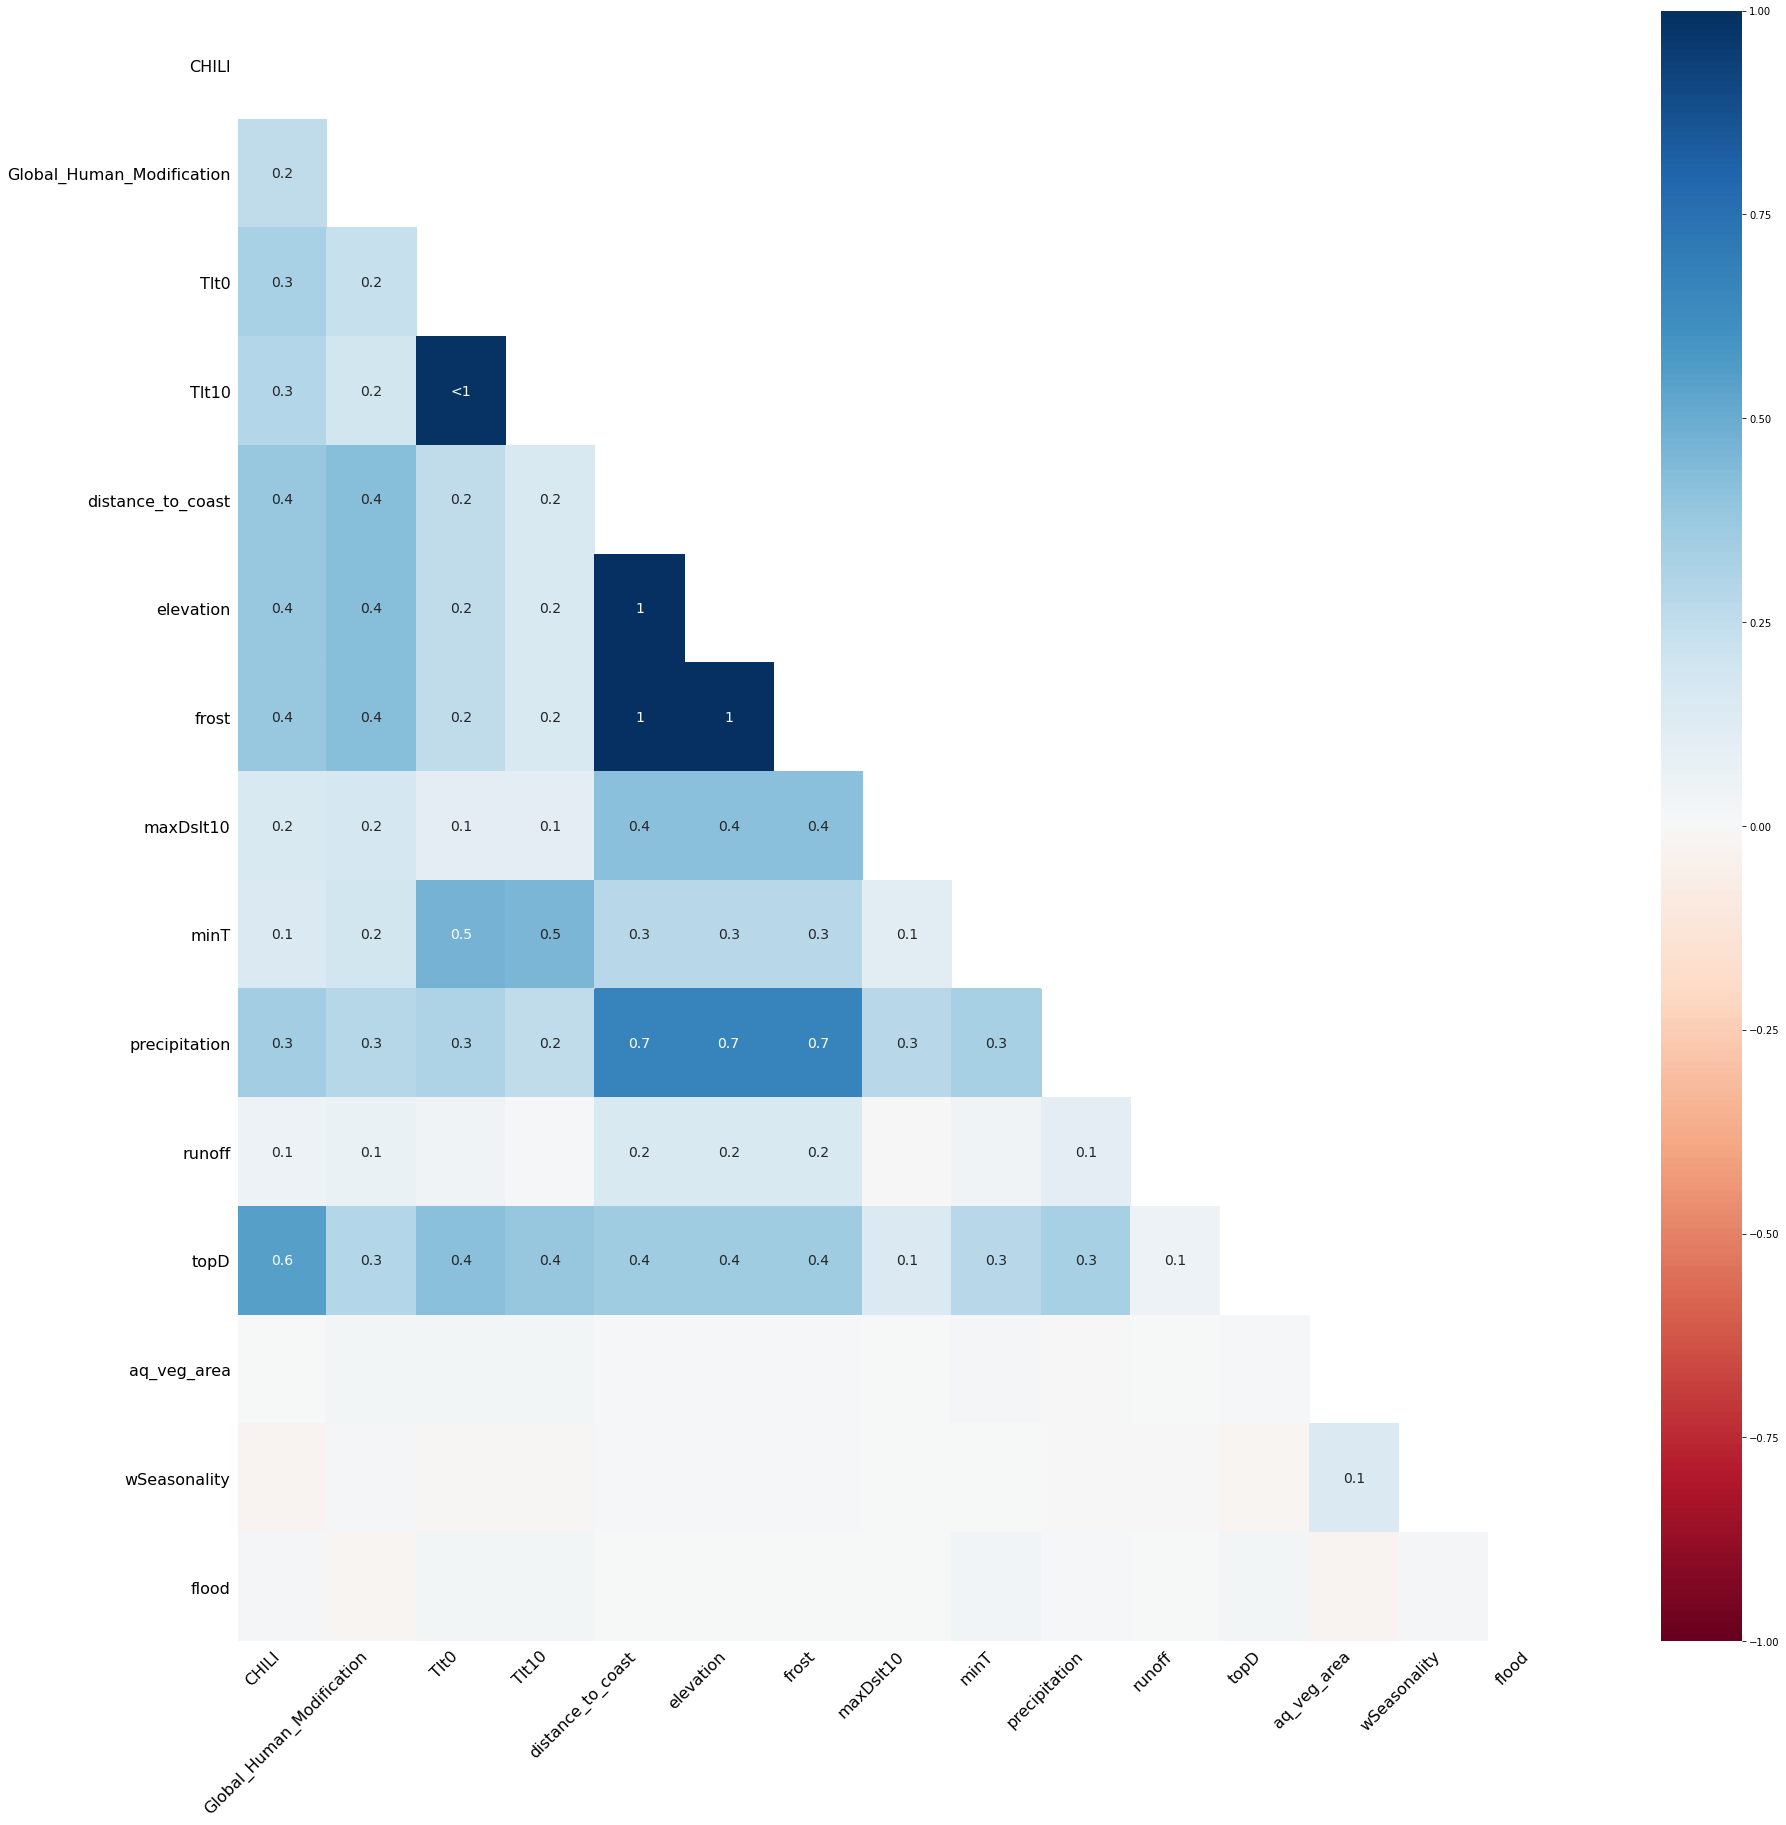

In [25]:
msno.heatmap(df, figsize=(30,30))

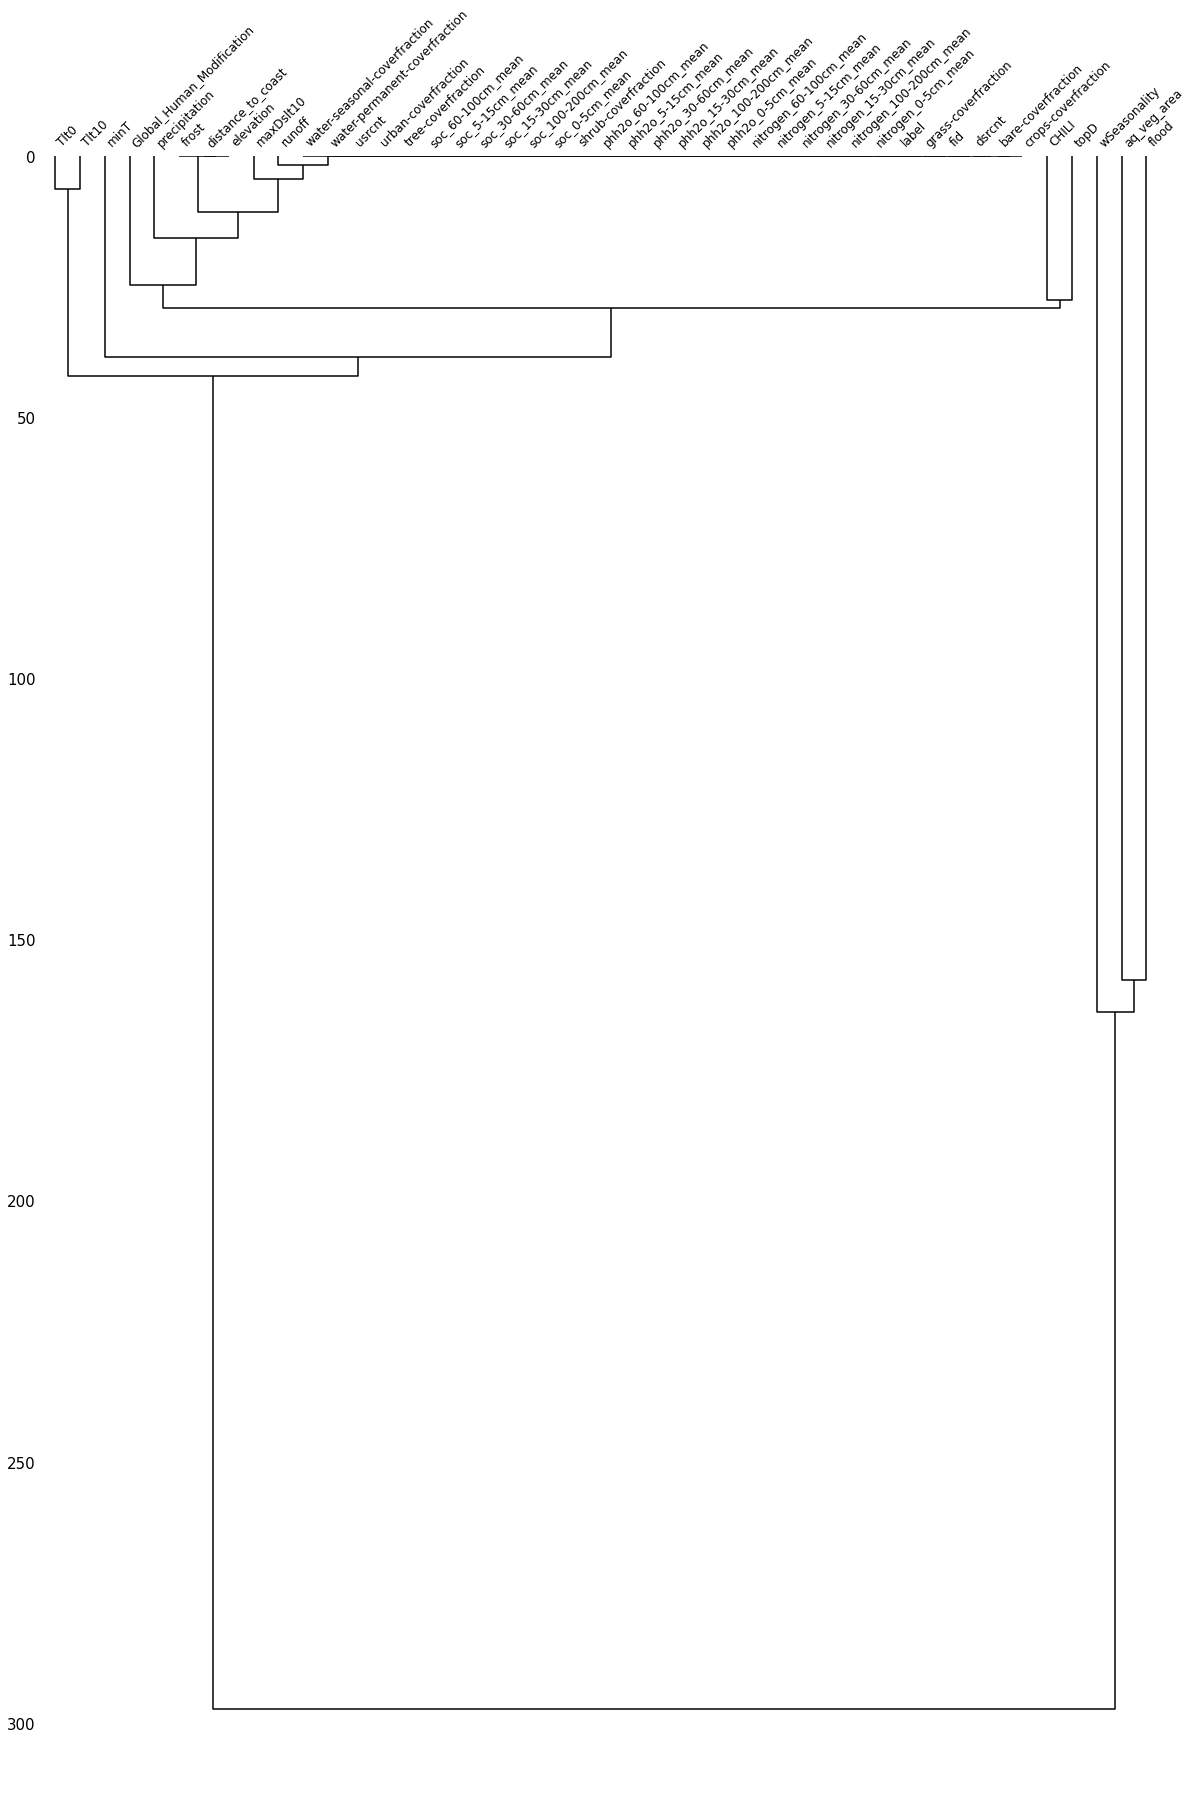

In [26]:
msno.dendrogram(df, inline=True, fontsize=12, figsize=(20,30))

In [16]:
print(df.label.value_counts())

0    75144
1    27030
Name: label, dtype: int64


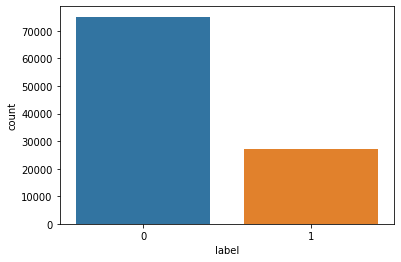

In [17]:
sns.countplot(df['label']);

In [18]:
print(df.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 102174 entries, 0 to 104894
Columns: 118 entries, CHILI to eroded lands
dtypes: float64(115), int64(3)
memory usage: 97.8 MB
None


In [17]:
# Analyzing data
report=sweetviz.analyze(df)
# Generating report
report.show_html('eda_report.html')

NameError: name 'sweetviz' is not defined

In [20]:
df_list = [d for _, d in df.groupby(['label'])]
df0 = df_list[0]
df1 = df_list[1]

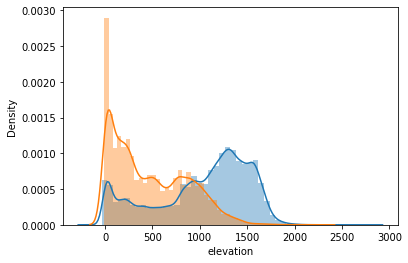

In [21]:
#histogram
sns.distplot(df0['elevation']);
sns.distplot(df1['elevation']);

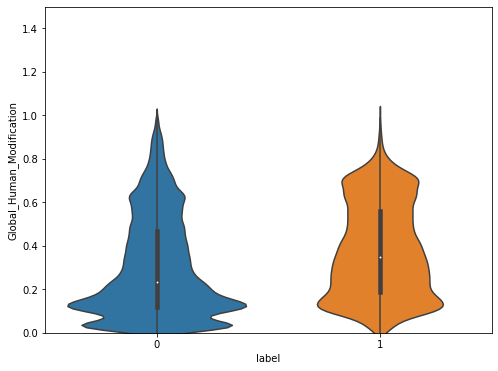

In [22]:
#box plot overallqual/saleprice
var = 'Global_Human_Modification'
data = pd.concat([df['label'], df[var]], axis=1)
f, ax = plt.subplots(figsize=(8, 6))
fig = sns.violinplot(x="label", y=var, data=data)
fig.axis(ymin=0, ymax=1.5);

In [33]:
sns.set(style="darkgrid")
 
# Grouped violinplot
sns.violinplot(x="day", y="frost", hue="smoker", data=df, palette="Pastel1")
plt.show()

ValueError: Could not interpret input 'day'

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.


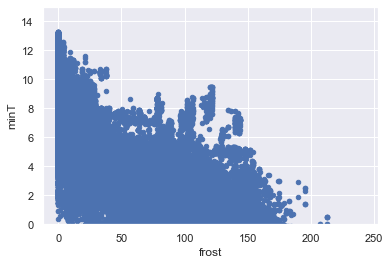

In [34]:
#scatter plot grlivarea/saleprice
var = 'frost'
data = pd.concat([df['minT'], df[var]], axis=1)
data.plot.scatter(x=var, y='minT', ylim=(0,15));

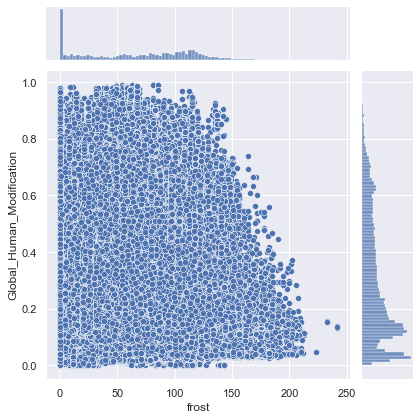

In [35]:
sns.jointplot(x=df['frost'], y=df['Global_Human_Modification']);

In [ ]:
# Custom the histogram:
sns.jointplot(x=df["frost"], y=df["Global_Human_Modification"], kind='kde', marginal_kws=dict(bins=15))

plt.show()

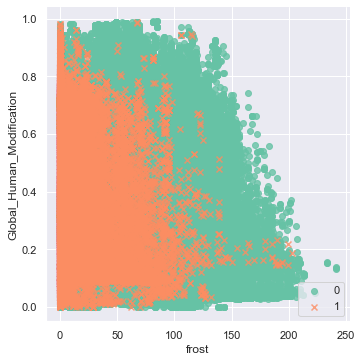

In [36]:
# Use the 'hue' argument to provide a factor variable
sns.lmplot( x="frost", y="Global_Human_Modification", data=df, fit_reg=False, hue='label', legend=False, markers=["o", "x"], palette="Set2")
 
# Move the legend to an empty part of the plot
plt.legend(loc='lower right')

plt.show()

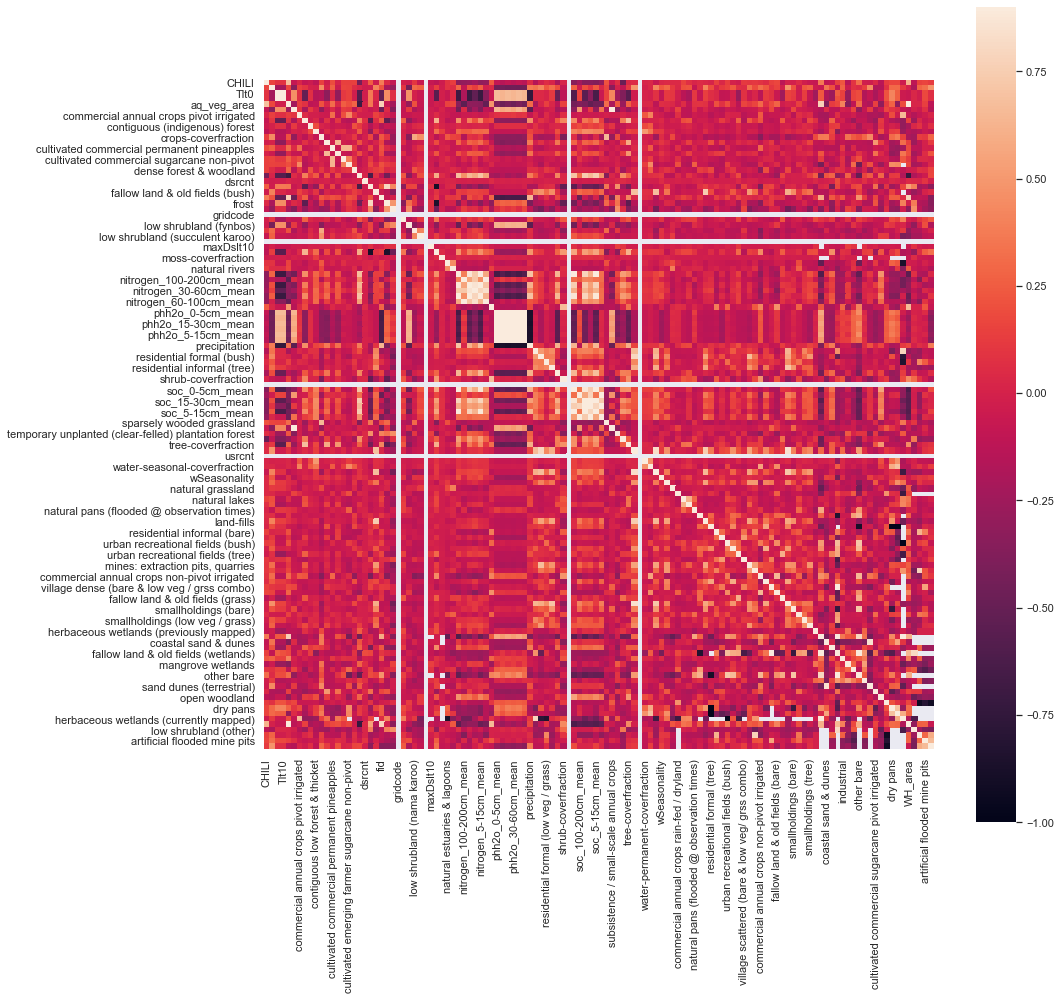

In [37]:
#correlation matrix
corrmat = df.corr()
f, ax = plt.subplots(figsize=(15, 15))
sns.heatmap(corrmat, vmax=.9, square=True);

In [60]:
print(df.columns)

Index(['CHILI', 'Global_Human_Modification', 'Tlt0', 'Tlt10', 'WH_area',
       'aq_veg_area', 'bare-coverfraction', 'crops-coverfraction',
       'distance_to_coast', 'dsrcnt', 'elevation', 'frost', 'ft_area',
       'grass-coverfraction', 'gridcode', 'inter_comp', 'intra_comp', 'label',
       'maxDslt10', 'minT', 'moss-coverfraction', 'multiple_species',
       'nitrogen_0-5cm_mean', 'nitrogen_100-200cm_mean',
       'nitrogen_15-30cm_mean', 'nitrogen_30-60cm_mean',
       'nitrogen_5-15cm_mean', 'nitrogen_60-100cm_mean', 'phh2o_0-5cm_mean',
       'phh2o_100-200cm_mean', 'phh2o_15-30cm_mean', 'phh2o_30-60cm_mean',
       'phh2o_5-15cm_mean', 'phh2o_60-100cm_mean', 'precipitation',
       'shrub-coverfraction', 'snow-coverfraction', 'soc_0-5cm_mean',
       'soc_100-200cm_mean', 'soc_15-30cm_mean', 'soc_30-60cm_mean',
       'soc_5-15cm_mean', 'soc_60-100cm_mean', 'topD', 'total_comp',
       'tree-coverfraction', 'urban-coverfraction', 'usrcnt', 'wSeasonality',
       'water-perman

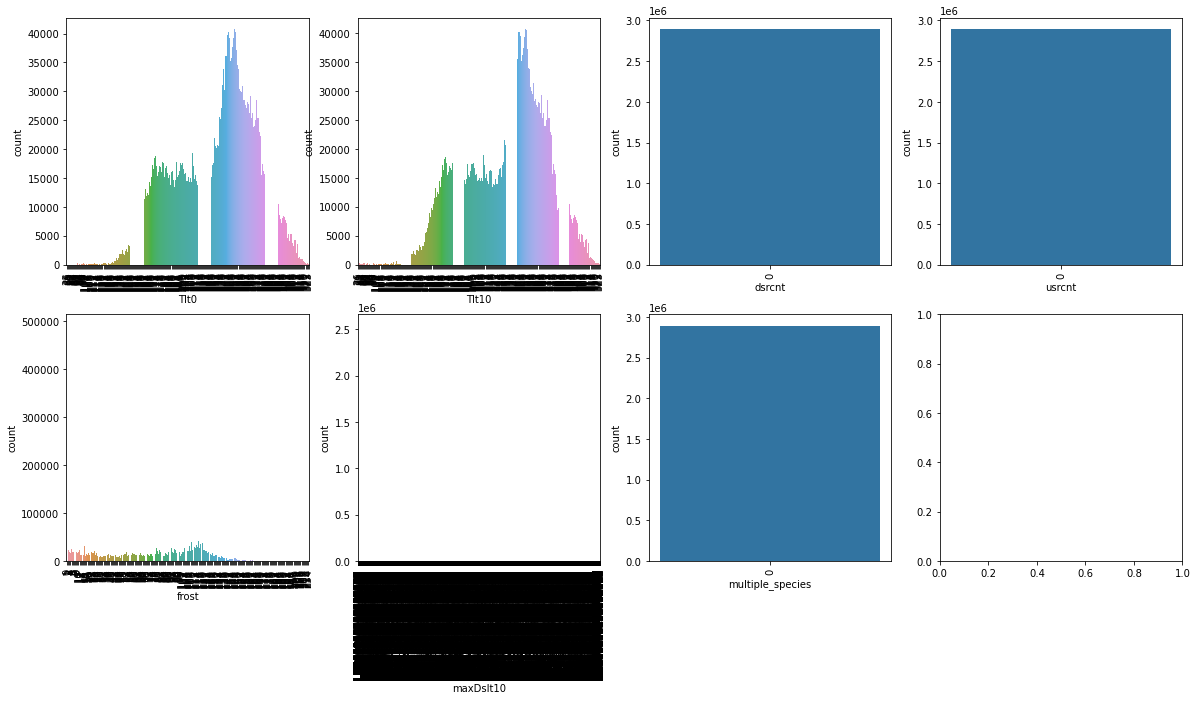

In [63]:
categorical = [
  'Tlt0', 'Tlt10', 'dsrcnt', 'usrcnt', 'frost', 'maxDslt10',  'multiple_species'
]
fig, ax = plt.subplots(2, 4, figsize=(20, 10))
for variable, subplot in zip(categorical, ax.flatten()):
    sns.countplot(df[variable], ax=subplot)
    for label in subplot.get_xticklabels():
        label.set_rotation(90)

In [ ]:
k = 10 #number of variables for heatmap
cols = corrmat.nlargest(k, 'SalePrice')['SalePrice'].index
cm = np.corrcoef(df_train[cols].values.T)
sns.set(font_scale=1.25)
hm = sns.heatmap(cm, cbar=True, annot=True, square=True, fmt='.2f', annot_kws={'size': 10}, yticklabels=cols.values, xticklabels=cols.values)
plt.show()

### Feature selection

In [105]:
list(df)

['CHILI',
 'Global_Human_Modification',
 'Tlt0',
 'Tlt10',
 'aq_veg_area',
 'bare-coverfraction',
 'commercial annual crops pivot irrigated',
 'contiguous & dense plantation forest',
 'contiguous (indigenous) forest',
 'contiguous low forest & thicket',
 'crops-coverfraction',
 'cultivated commercial permanent orchards',
 'cultivated commercial permanent pineapples',
 'cultivated commercial permanent vines',
 'cultivated commercial sugarcane non-pivot',
 'cultivated emerging farmer sugarcane non-pivot',
 'dense forest & woodland',
 'distance_to_coast',
 'dsrcnt',
 'elevation',
 'fallow land & old fields (bush)',
 'fid',
 'frost',
 'grass-coverfraction',
 'label',
 'low shrubland (fynbos)',
 'low shrubland (nama karoo)',
 'low shrubland (succulent karoo)',
 'maxDslt10',
 'minT',
 'natural estuaries & lagoons',
 'natural rivers',
 'nitrogen_0-5cm_mean',
 'nitrogen_100-200cm_mean',
 'nitrogen_15-30cm_mean',
 'nitrogen_30-60cm_mean',
 'nitrogen_5-15cm_mean',
 'nitrogen_60-100cm_mean',
 'op

In [19]:
# remove irrelevant variables
df = df.drop(['maxDslt10','usrcnt'],axis=1)

In [20]:
# Remove redundant features by selcting one feature from the cluster
X = df.drop(['label','fid', *FLC],axis=1)
Y = df[['label']]

<AxesSubplot:>

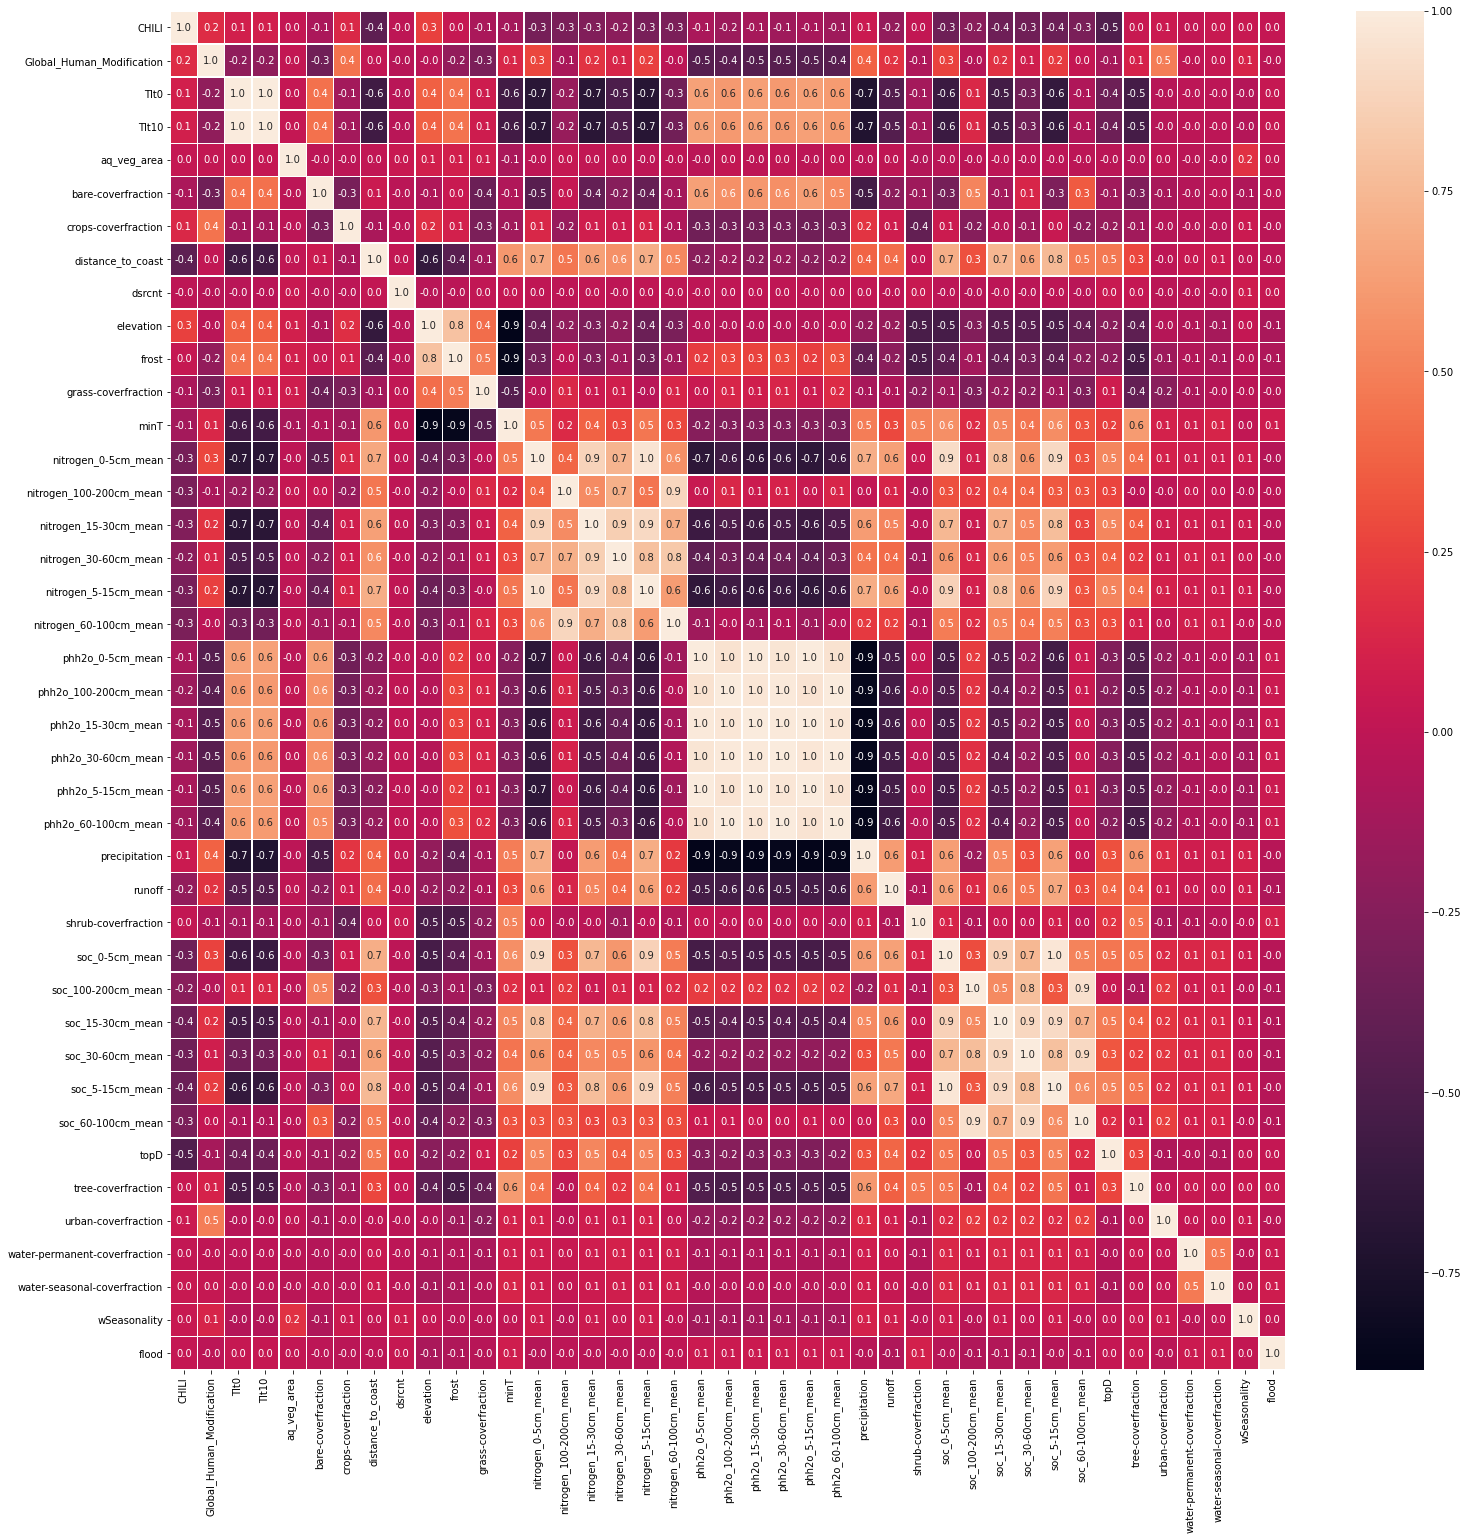

In [78]:
#correlation map
corr = X.corr()
f,ax = plt.subplots(figsize=(25, 25))
sns.heatmap(corr, annot=True, linewidths=.5, fmt= '.1f',ax=ax)

In [21]:
#redundant features
red_fts = ['Tlt0','nitrogen_0-5cm_mean', 'nitrogen_15-30cm_mean','nitrogen_5-15cm_mean','Tlt10','nitrogen_100-200cm_mean',
          'nitrogen_30-60cm_mean','phh2o_0-5cm_mean','phh2o_100-200cm_mean', 'phh2o_15-30cm_mean','phh2o_30-60cm_mean', 'phh2o_60-100cm_mean',
             'phh2o_5-15cm_mean', 'phh2o_60-100cm_mean','soc_0-5cm_mean', 'soc_15-30cm_mean','soc_30-60cm_mean', 'soc_60-100cm_mean',
             'soc_5-15cm_mean','frost', 'elevation']
df = df.drop([*red_fts], axis=1)

<AxesSubplot:>

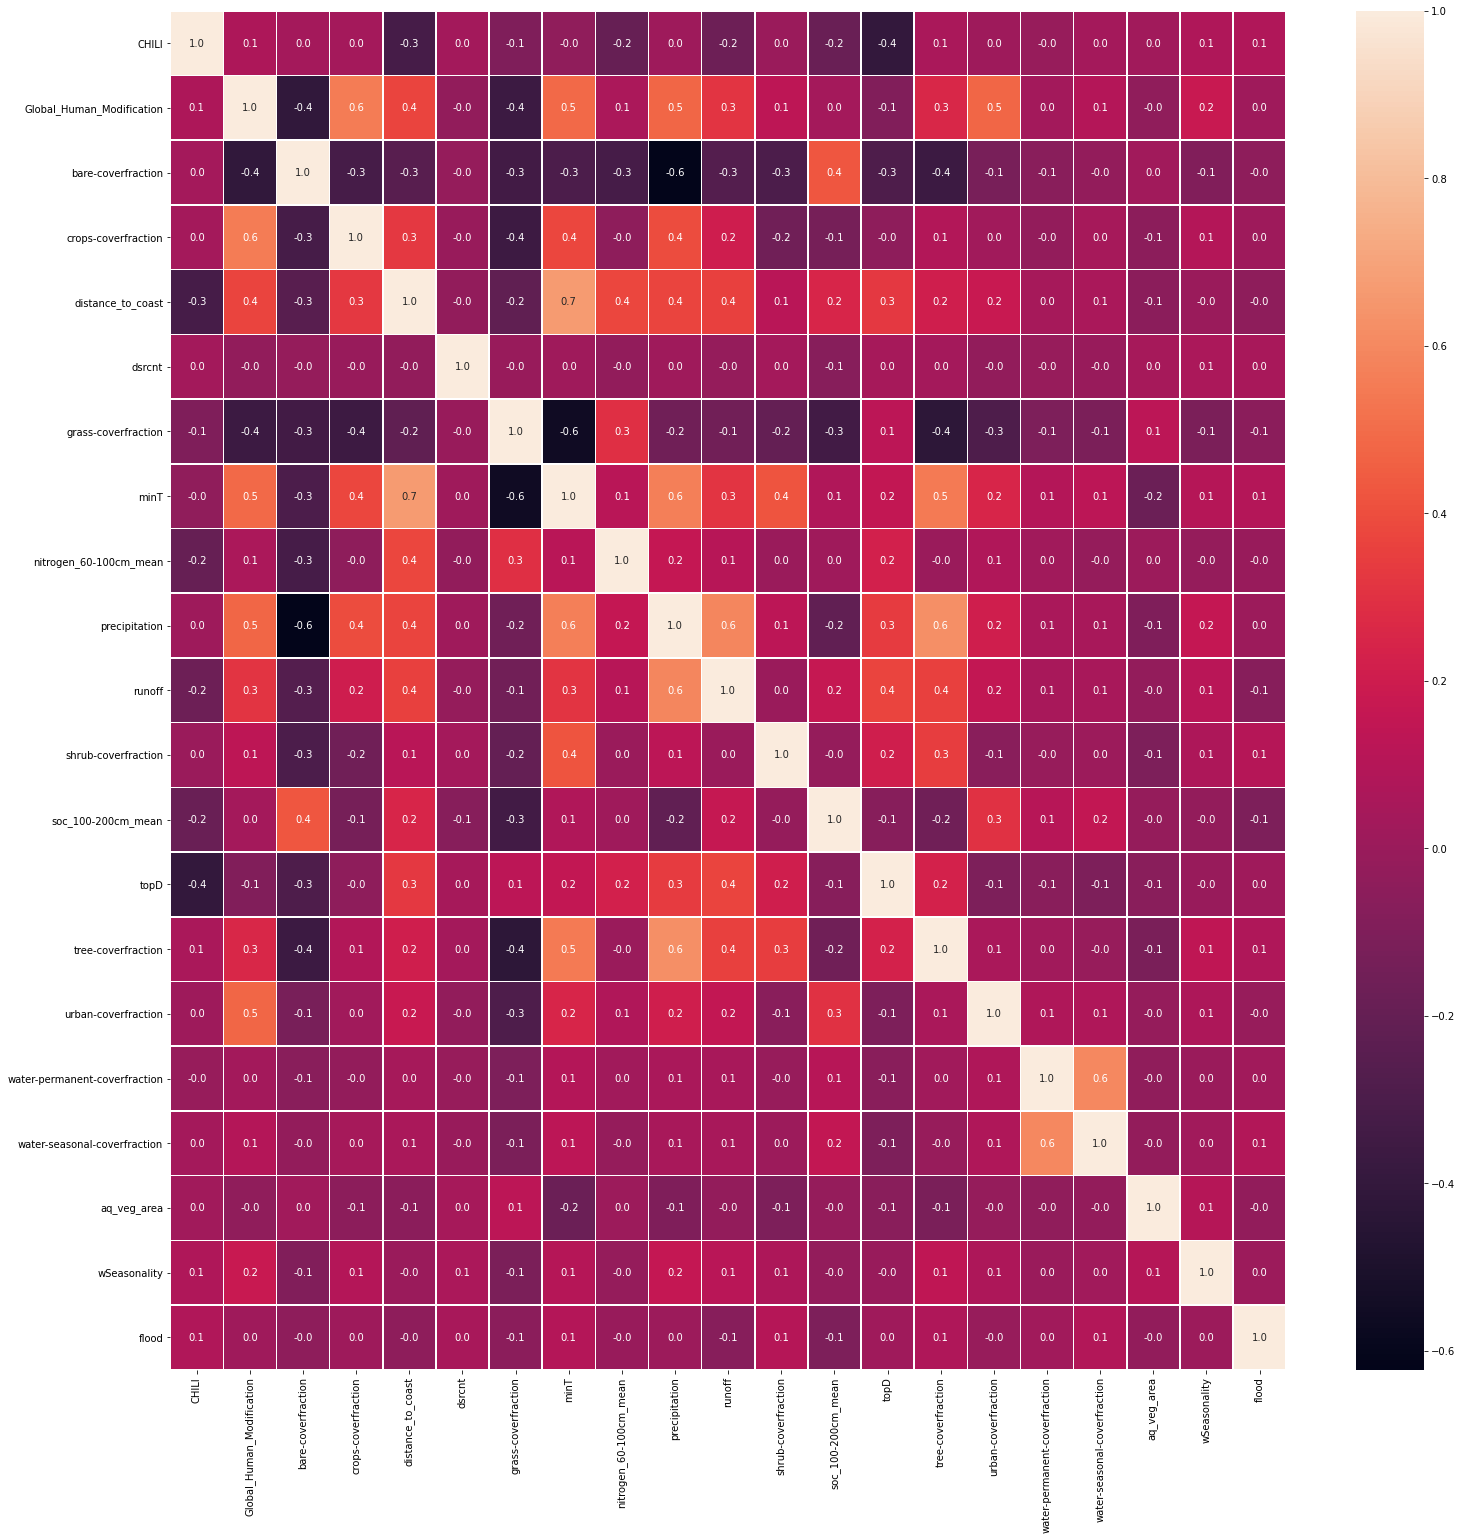

In [43]:
X = df.drop(['label','fid', *FLC],axis=1)
corr = X.corr()
#correlation map
f,ax = plt.subplots(figsize=(25, 25))
sns.heatmap(corr, annot=True, linewidths=.5, fmt= '.1f',ax=ax)

In [109]:
X = df.drop(['label','fid', *FLC],axis=1)
Y = df[['label']]

In [28]:
from sklearn.ensemble import ExtraTreesClassifier

# feature extraction
model = ExtraTreesClassifier(n_estimators=50)
model.fit(X, Y)
print(model.feature_importances_)

[0.02601322 0.03772337 0.01793568 0.04538407 0.04975171 0.07144305
 0.01433111 0.05652508 0.12252333 0.04671059 0.04903887 0.04358373
 0.06866909 0.04706245 0.03858308 0.06052672 0.0392898  0.03662617
 0.04722256 0.05320327 0.02785305]


      scores                           vars
0   0.026013                          CHILI
1   0.037723      Global_Human_Modification
2   0.017936                    aq_veg_area
3   0.045384             bare-coverfraction
4   0.049752            crops-coverfraction
5   0.071443              distance_to_coast
6   0.014331                         dsrcnt
7   0.056525            grass-coverfraction
8   0.122523                           minT
9   0.046711         nitrogen_60-100cm_mean
10  0.049039                  precipitation
11  0.043584                         runoff
12  0.068669            shrub-coverfraction
13  0.047062             soc_100-200cm_mean
14  0.038583                           topD
15  0.060527             tree-coverfraction
16  0.039290            urban-coverfraction
17  0.036626  water-permanent-coverfraction
18  0.047223   water-seasonal-coverfraction
19  0.053203                   wSeasonality
20  0.027853                          flood


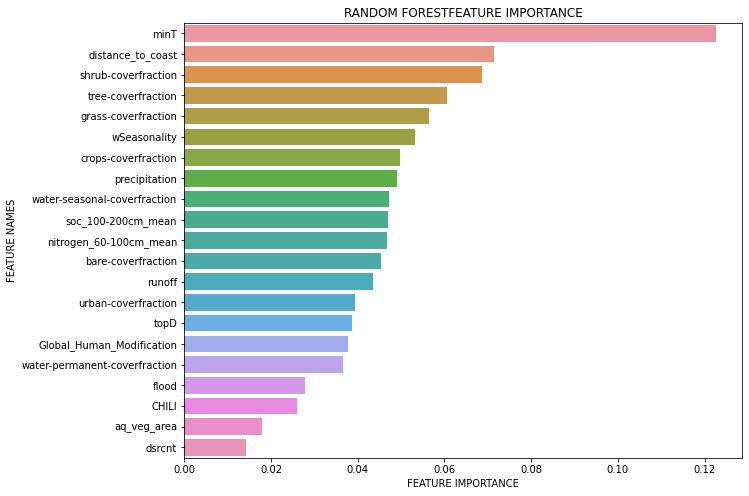

In [29]:
var_imp = pd.DataFrame()
var_imp['scores']= model.feature_importances_
var_imp['vars'] = X.columns
print(var_imp)

def plot_feature_importance(importance,names,model_type):

    #Create arrays from feature importance and feature names
    feature_importance = np.array(importance)
    feature_names = np.array(names)

    #Create a DataFrame using a Dictionary
    data={'feature_names':feature_names,'feature_importance':feature_importance}
    fi_df = pd.DataFrame(data)

    #Sort the DataFrame in order decreasing feature importance
    fi_df.sort_values(by=['feature_importance'], ascending=False,inplace=True)

    #Define size of bar plot
    plt.figure(figsize=(10,8))
    #Plot Searborn bar chart
    sns.barplot(x=fi_df['feature_importance'], y=fi_df['feature_names'])
    #Add chart labels
    plt.title(model_type + 'FEATURE IMPORTANCE')
    plt.xlabel('FEATURE IMPORTANCE')
    plt.ylabel('FEATURE NAMES')

plot_feature_importance(model.feature_importances_,X.columns,'RANDOM FOREST')

In [25]:
# Since CHILI is not an important predictor- we drop it
# 'CHILI','dsrcnt','aq_veg_area','flood','water-permanent-coverfraction','Global_Human_Modification'
X = df.drop(['label','fid',*FLC], axis= 1)
y = df[['label']]

In [26]:
list(X)

['CHILI',
 'Global_Human_Modification',
 'bare-coverfraction',
 'crops-coverfraction',
 'distance_to_coast',
 'dsrcnt',
 'grass-coverfraction',
 'minT',
 'nitrogen_60-100cm_mean',
 'precipitation',
 'runoff',
 'shrub-coverfraction',
 'soc_100-200cm_mean',
 'topD',
 'tree-coverfraction',
 'urban-coverfraction',
 'water-permanent-coverfraction',
 'water-seasonal-coverfraction',
 'aq_veg_area',
 'wSeasonality',
 'flood']

In [32]:
# VIF dataframe
from statsmodels.stats.outliers_influence import variance_inflation_factor
vif_data = pd.DataFrame()
vif_data["feature"] = X.columns

# calculating VIF for each feature
vif_data["VIF"] = [variance_inflation_factor(X.values, i)for i in range(len(X.columns))]

print(vif_data)

                                              feature        VIF
0                                  bare-coverfraction  12.503861
1             commercial annual crops pivot irrigated   1.594891
2                contiguous & dense plantation forest   4.688018
3                      contiguous (indigenous) forest   1.227494
4                     contiguous low forest & thicket   1.654767
5                                 crops-coverfraction   7.720646
6            cultivated commercial permanent orchards   2.433080
7          cultivated commercial permanent pineapples   2.670199
8               cultivated commercial permanent vines   1.756024
9           cultivated commercial sugarcane non-pivot   1.777763
10     cultivated emerging farmer sugarcane non-pivot   2.201545
11                            dense forest & woodland   1.687418
12                                  distance_to_coast  12.548817
13                    fallow land & old fields (bush)   2.336601
14                       

In [3]:
from sklearn.feature_selection import RFECV

# The "accuracy" scoring is proportional to the number of correct classifications
clf_rf_4 = RandomForestClassifier(n_jobs = -1, verbose=1)

rfecv = RFECV(estimator=clf_rf_4, step=1, cv=2,scoring='f1')   #5-fold cross-validation
rfecv = rfecv.fit(X, Y)

print('Optimal number of features :', rfecv.n_features_)
print('Best features :', X.columns[rfecv.support_])

# Plot number of features VS. cross-validation scores
import matplotlib.pyplot as plt
plt.figure()
plt.xlabel("Number of features selected")
plt.ylabel("Cross validation score of number of selected features")
plt.plot(range(1, len(rfecv.grid_scores_) + 1), rfecv.grid_scores_)
plt.show()

NameError: name 'X' is not defined

In [71]:
from sklearn import metrics
sorted(metrics.SCORERS.keys())

['accuracy',
 'adjusted_mutual_info_score',
 'adjusted_rand_score',
 'average_precision',
 'balanced_accuracy',
 'completeness_score',
 'explained_variance',
 'f1',
 'f1_macro',
 'f1_micro',
 'f1_samples',
 'f1_weighted',
 'fowlkes_mallows_score',
 'homogeneity_score',
 'jaccard',
 'jaccard_macro',
 'jaccard_micro',
 'jaccard_samples',
 'jaccard_weighted',
 'max_error',
 'mutual_info_score',
 'neg_brier_score',
 'neg_log_loss',
 'neg_mean_absolute_error',
 'neg_mean_absolute_percentage_error',
 'neg_mean_gamma_deviance',
 'neg_mean_poisson_deviance',
 'neg_mean_squared_error',
 'neg_mean_squared_log_error',
 'neg_median_absolute_error',
 'neg_root_mean_squared_error',
 'normalized_mutual_info_score',
 'precision',
 'precision_macro',
 'precision_micro',
 'precision_samples',
 'precision_weighted',
 'r2',
 'rand_score',
 'recall',
 'recall_macro',
 'recall_micro',
 'recall_samples',
 'recall_weighted',
 'roc_auc',
 'roc_auc_ovo',
 'roc_auc_ovo_weighted',
 'roc_auc_ovr',
 'roc_auc_ovr_weighted',
 'top_k_accuracy',
 'v_measure_score']

## Step 5: Modelling

#### Spatial Cross Validation

In [55]:
from sklearn.model_selection import GroupKFold, cross_val_predict
blocks = df['fid'].values
group_kfold = GroupKFold(n_splits=5)
# Generator for the train/test indices
block_kfold = group_kfold.split(X, y, blocks)  
# Create a nested list of train and test indices for each fold
train_indices, test_indices = [list(traintest) for traintest in zip(*block_kfold)]
block_cv = [*zip(train_indices,test_indices)]
# predictions = cross_val_predict(model, X, y, cv=block_cv)

In [113]:
list(X)

['CHILI',
 'Global_Human_Modification',
 'aq_veg_area',
 'bare-coverfraction',
 'crops-coverfraction',
 'distance_to_coast',
 'dsrcnt',
 'grass-coverfraction',
 'minT',
 'nitrogen_60-100cm_mean',
 'precipitation',
 'runoff',
 'shrub-coverfraction',
 'soc_100-200cm_mean',
 'topD',
 'tree-coverfraction',
 'urban-coverfraction',
 'water-permanent-coverfraction',
 'water-seasonal-coverfraction',
 'wSeasonality',
 'flood']

In [30]:
# Sanity check
for i in range(0,9):
    arr = block_cv[i][0]
    print('block',i)
    print(df.iloc[arr, :].label.value_counts('label'))

block 0
0    0.751142
1    0.248858
Name: label, dtype: float64
block 1
0    0.723749
1    0.276251
Name: label, dtype: float64
block 2
0    0.726254
1    0.273746
Name: label, dtype: float64
block 3
0    0.726784
1    0.273216
Name: label, dtype: float64
block 4
0    0.731962
1    0.268038
Name: label, dtype: float64
block 5
0    0.735919
1    0.264081
Name: label, dtype: float64
block 6
0    0.75022
1    0.24978
Name: label, dtype: float64
block 7
0    0.727711
1    0.272289
Name: label, dtype: float64
block 8
0    0.737523
1    0.262477
Name: label, dtype: float64


In [56]:
from sklearn.model_selection import cross_validate
from sklearn.ensemble import ExtraTreesClassifier

model = ExtraTreesClassifier(n_estimators=100, n_jobs = -1)
# model = ensemble.RandomForestClassifier(n_estimators=50,n_jobs = -1)
# Since CHILI is not an important predictor- we drop it
# X = df.drop(['CHILI','dsrcnt','aq_veg_area','flood','water-permanent-coverfraction','Global_Human_Modification','label','fid',*FLC], axis= 1)
# y = df[['label']]

In [57]:
from sklearn.metrics import make_scorer
from sklearn import metrics
custom_scorer = {'accuracy': make_scorer(metrics.accuracy_score),
                 'balanced_accuracy': make_scorer(metrics.balanced_accuracy_score),
                 'precision': make_scorer(metrics.precision_score, average='macro'),
                 'recall': make_scorer(metrics.recall_score, average='macro'),
                 'f1': make_scorer(metrics.f1_score, average='macro'),
                 'MCC':make_scorer(metrics.matthews_corrcoef)
                 }
cv_results = cross_validate(model, X,y, scoring = custom_scorer, cv=block_cv, n_jobs=-1)

In [58]:
cv_results['test_precision'].mean()

0.8771816066883236

In [59]:
cv_results['test_recall'].mean()

0.7981378906738053

In [60]:
cv_results['test_f1'].mean()

0.8226382374102293

In [61]:
cv_results['test_balanced_accuracy'].mean()

0.7981378906738053

In [62]:
cv_results['test_MCC'].mean()

0.6694325618144099

In [63]:
cv_results

{'fit_time': array([9.15805197, 9.55205226, 9.60505056, 9.84105206, 9.57705021]),
 'score_time': array([0.72499514, 0.30899787, 0.46099782, 0.29499698, 0.45299864]),
 'test_accuracy': array([0.79530218, 0.85040372, 0.88754588, 0.96046   , 0.87814427]),
 'test_balanced_accuracy': array([0.7270293 , 0.79579683, 0.75318382, 0.90512613, 0.80955337]),
 'test_precision': array([0.838947  , 0.82953028, 0.87541361, 0.96635285, 0.87566431]),
 'test_recall': array([0.7270293 , 0.79579683, 0.75318382, 0.90512613, 0.80955337]),
 'test_f1': array([0.74397088, 0.80959998, 0.79354112, 0.93199398, 0.83408523]),
 'test_MCC': array([0.5548005 , 0.62441657, 0.61659922, 0.86932554, 0.68202097])}

In [71]:
from sklearn.ensemble import ExtraTreesClassifier, RandomForestClassifier
rfc = RandomForestClassifier(n_jobs=-1)#
rfc.fit(X,y)
rfc_predict = rfc.predict(X)

print("=== Classification Report ===")
print(classification_report(y, rfc_predict))
print('\n')

print("=== Confusion Matrix ===")
cm_plot_labels=['WH_absence', 'WH_presence']
sns.set_style("white")
plot_confusion_matrix(confusion_matrix(y, rfc_predict), cm_plot_labels,title='Confusion Matrix', normalize = False)
print('\n')

=== Classification Report ===
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    215918
           1       1.00      1.00      1.00     26994

    accuracy                           1.00    242912
   macro avg       1.00      1.00      1.00    242912
weighted avg       1.00      1.00      1.00    242912



=== Confusion Matrix ===


NameError: name 'plot_confusion_matrix' is not defined